In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.types import * 
import pyspark.sql.functions as F
from pyspark.sql.functions import col, asc,desc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql import SQLContext
from pyspark.mllib.stat import Statistics
import pandas as pd
from pyspark.sql.functions import udf
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler,StandardScaler
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix

spark=SparkSession.builder \
.master ("local[*]")\
.appName("part3")\
.getOrCreate()

In [3]:
sc=spark.sparkContext
sqlContext=SQLContext(sc)

C:\Apps\spark-3.3.0-bin-hadoop3\python\pyspark\sql\context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [4]:
import os
os.getcwd()

'C:\\Users\\303an\\OneDrive\\Desktop\\BAnDS\\Fall_2022\\5753\\Spark'

In [5]:
from platform import python_version

print(python_version())

3.9.9


In [6]:
sc.version #spark version

'3.3.0'

## Reading Data 

In [54]:
df=spark.read \
 .option("header","True")\
 .option("inferSchema","True")\
 .option("sep",";")\
 .csv("./XYZ_Bank_Deposit_Data_Classification.csv")
print("There are",df.count(),"rows",len(df.columns),
      "columns" ,"in the data.") 

There are 41188 rows 21 columns in the data.


In [55]:
df.show(4)

+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|age|      job|marital|  education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp.var.rate|cons.price.idx|cons.conf.idx|euribor3m|nr.employed|  y|
+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
| 56|housemaid|married|   basic.4y|     no|     no|  no|telephone|  may|        mon|     261|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|
| 57| services|married|high.school|unknown|     no|  no|telephone|  may|        mon|     149|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|
| 37| serv

In [56]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp.var.rate: double (nullable = true)
 |-- cons.price.idx: double (nullable = true)
 |-- cons.conf.idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr.employed: double (nullable = true)
 |-- y: string (nullable = true)



In [119]:
df.groupby("y").count().show()

+---+-----+
|  y|count|
+---+-----+
| no|36548|
|yes| 4640|
+---+-----+



In [58]:
df.describe().show()

+-------+------------------+-------+--------+---------+-------+-------+-----+---------+-----+-----------+------------------+-----------------+-----------------+-------------------+--------+-------------------+------------------+-------------------+------------------+-----------------+-----+
|summary|               age|    job| marital|education|default|housing| loan|  contact|month|day_of_week|          duration|         campaign|            pdays|           previous|poutcome|       emp.var.rate|    cons.price.idx|      cons.conf.idx|         euribor3m|      nr.employed|    y|
+-------+------------------+-------+--------+---------+-------+-------+-----+---------+-----+-----------+------------------+-----------------+-----------------+-------------------+--------+-------------------+------------------+-------------------+------------------+-----------------+-----+
|  count|             41188|  41188|   41188|    41188|  41188|  41188|41188|    41188|41188|      41188|             41188|

### Pandas dataframe is prettier than Spark DataFrame.show()

In [149]:
import pandas as pd
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
age,56,57,37,40,56
job,housemaid,services,services,admin.,services
marital,married,married,married,married,married
education,basic.4y,high.school,high.school,basic.6y,high.school
default,no,unknown,no,no,no
housing,no,no,yes,no,no
loan,no,no,no,no,yes
contact,telephone,telephone,telephone,telephone,telephone
month,may,may,may,may,may
day_of_week,mon,mon,mon,mon,mon


### Our Classes are imbalanced

In [152]:
df.groupby("y").count().toPandas()

,y,count
0,no,36548
1,yes,4640


### Summary statistics for numeric variables

In [153]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,41188,40.02406040594348,10.421249980934043,17,98
duration,41188,258.2850101971448,259.27924883646455,0,4918
campaign,41188,2.567592502670681,2.770013542902331,1,56
pdays,41188,962.4754540157328,186.910907344741,0,999
previous,41188,0.17296299893172767,0.49490107983928927,0,7


## Change Column Names with a Period in Them

In [154]:
df2 = df.withColumnRenamed("emp.var.rate","empvarrate").withColumnRenamed("cons.price.idx","conspriceidx")
df2 = df2.withColumnRenamed("cons.conf.idx","consconfidx").withColumnRenamed("nr.employed","nremployed")
df2.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- empvarrate: double (nullable = true)
 |-- conspriceidx: double (nullable = true)
 |-- consconfidx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nremployed: double (nullable = true)
 |-- y: string (nullable = true)



## Distinguishing Which Columns are Character/Categorical and Numerical

In [155]:
dftest=df2

In [61]:
char_columns = [i.name for i in df2.schema.fields if isinstance(i.dataType, StringType)]
print("There are", len(char_columns), "categorical columns in the data")
print(char_columns)

There are 11 categorical columns in the data
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']


In [62]:
int_columns = [i.name for i in df2.schema.fields if isinstance(i.dataType, IntegerType) | isinstance(i.dataType, DoubleType)]
print("There are", len(int_columns), "numerical columns in the data")
print(int_columns)

There are 10 numerical columns in the data
['age', 'duration', 'campaign', 'pdays', 'previous', 'empvarrate', 'conspriceidx', 'consconfidx', 'euribor3m', 'nremployed']


## Null Values

In [63]:
from pyspark.sql.functions import isnan, when, count, col

df2.select([count(when(isnan(c), c)).alias(c) for c in df2.columns]).toPandas().head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,empvarrate,conspriceidx,consconfidx,euribor3m,nremployed,y
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
Dict_Null = {col:df2.filter(df2[col].isNull()).count() for col in df2.columns}
Dict_Null

{'age': 0,
 'job': 0,
 'marital': 0,
 'education': 0,
 'default': 0,
 'housing': 0,
 'loan': 0,
 'contact': 0,
 'month': 0,
 'day_of_week': 0,
 'duration': 0,
 'campaign': 0,
 'pdays': 0,
 'previous': 0,
 'poutcome': 0,
 'empvarrate': 0,
 'conspriceidx': 0,
 'consconfidx': 0,
 'euribor3m': 0,
 'nremployed': 0,
 'y': 0}

## Number of Distinct and Null Values in Each Column

In [65]:
for c in df2.columns:
    print(c, ":\n ", df2.filter(df2[c]=="?").count(), "null values\n ", df2.select(c).distinct().count(), "distinct values")
    print

age :
  0 null values
  78 distinct values
job :
  0 null values
  12 distinct values
marital :
  0 null values
  4 distinct values
education :
  0 null values
  8 distinct values
default :
  0 null values
  3 distinct values
housing :
  0 null values
  3 distinct values
loan :
  0 null values
  3 distinct values
contact :
  0 null values
  2 distinct values
month :
  0 null values
  10 distinct values
day_of_week :
  0 null values
  5 distinct values
duration :
  0 null values
  1544 distinct values
campaign :
  0 null values
  42 distinct values
pdays :
  0 null values
  27 distinct values
previous :
  0 null values
  8 distinct values
poutcome :
  0 null values
  3 distinct values
empvarrate :
  0 null values
  10 distinct values
conspriceidx :
  0 null values
  26 distinct values
consconfidx :
  0 null values
  26 distinct values
euribor3m :
  0 null values
  316 distinct values
nremployed :
  0 null values
  11 distinct values
y :
  0 null values
  2 distinct values


In [147]:
# cardinality for the categorical variables
from pyspark.sql.functions import countDistinct
string_features = [t[0] for t in df2.dtypes if t[1] == 'string']
cardinality = [countDistinct(c).alias(c) for c in string_features]
df2.select(cardinality).show()

+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+---+
|job|marital|education|default|housing|loan|contact|month|day_of_week|poutcome|  y|
+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+---+
| 12|      4|        8|      3|      3|   3|      2|   10|          5|       3|  2|
+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+---+



In [148]:
# total numeric variables
numeric_features = [t[0] for t in df2.dtypes if t[1] != 'string']
df2.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
label,41188,0.11265417111780131,0.3161734269429654,0.0,1.0
age,41188,40.02406040594348,10.421249980934043,17,98
duration,41188,258.2850101971448,259.27924883646455,0,4918
campaign,41188,2.567592502670681,2.770013542902331,1,56
pdays,41188,962.4754540157328,186.910907344741,0,999
previous,41188,0.17296299893172767,0.49490107983928927,0,7
empvarrate,41188,0.08188550063178966,1.57095974051703,-3.4,1.4
conspriceidx,41188,93.5756643682899,0.5788400489540823,92.201,94.767
consconfidx,41188,-40.502600271918276,4.628197856174573,-50.8,-26.9


## Distribution Plots

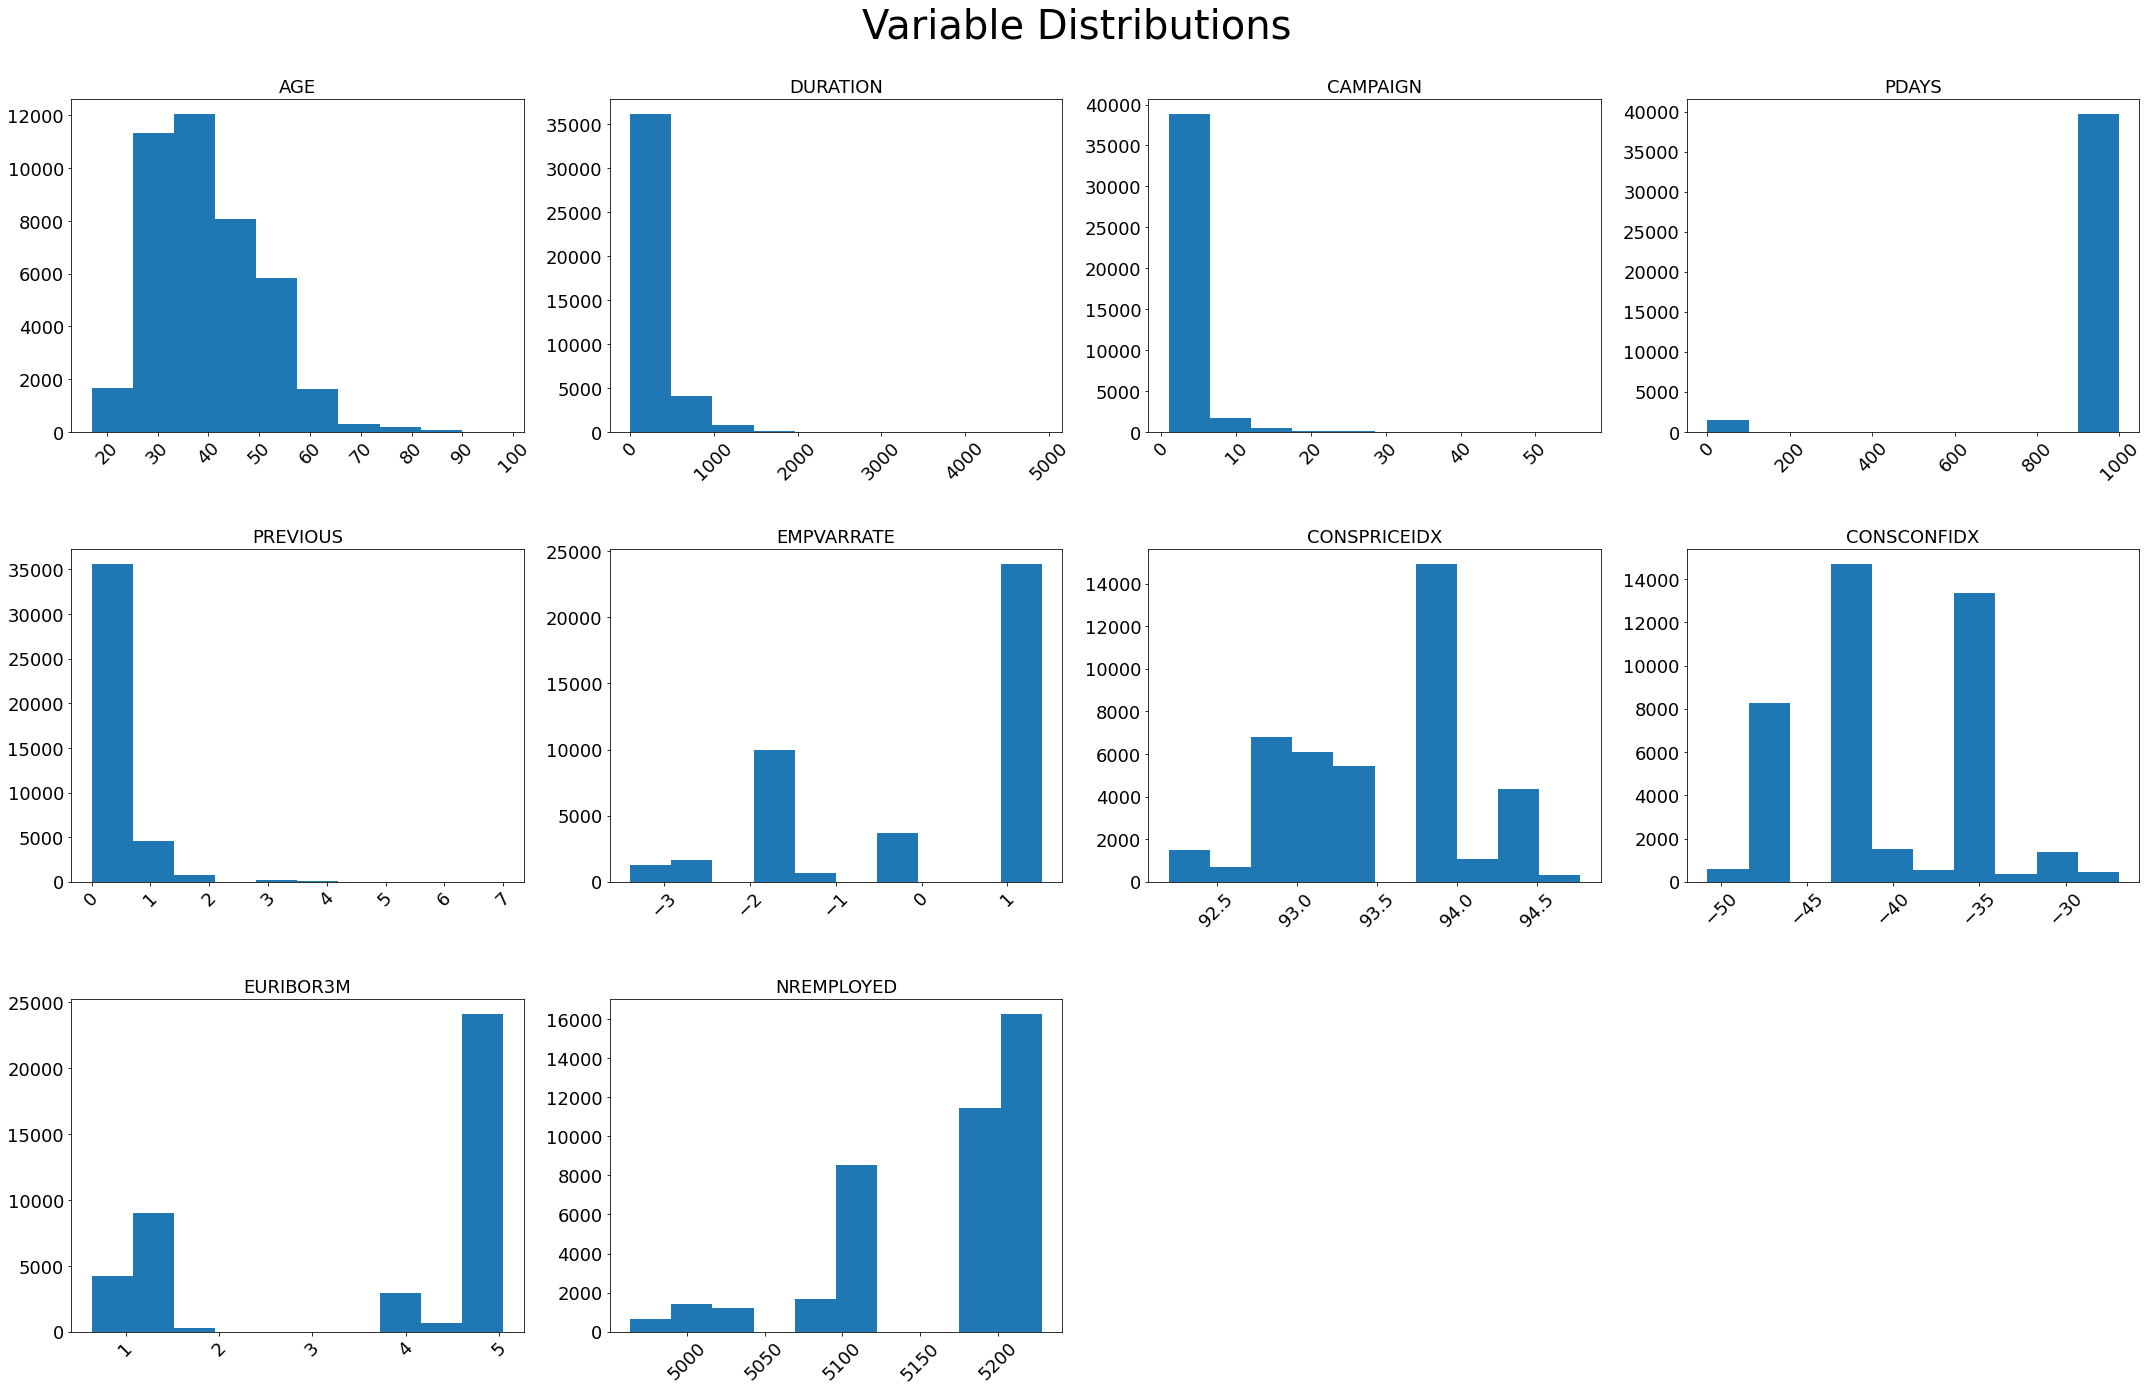

In [66]:
from matplotlib import cm
figures = plt.figure(figsize=(30,20))
sub_title = figures.suptitle("Variable Distributions", fontsize=40,
                  verticalalignment='center')

for c,numeric in zip(df2.toPandas().describe().columns, range(1,11)):

    axis = figures.add_subplot(3,4,numeric)
    axis.hist(df2.toPandas()[c])
    plt.grid(False)
    plt.xticks(rotation=45,fontsize=18)
    plt.yticks(fontsize=18)
    plt.title(c.upper(),fontsize=18)
plt.tight_layout()
sub_title.set_y(0.95)
figures.subplots_adjust(top=0.90,hspace = 0.35)
plt.show()

## Pearson Correlation

In [67]:
numeric_variables = [t[0] for t in df2.dtypes if t[1] != 'string']
numeric_variables_df=df2.select(numeric_variables)
numeric_variables_df.toPandas().head()

,age,duration,campaign,pdays,previous,empvarrate,conspriceidx,consconfidx,euribor3m,nremployed
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0


In [68]:
col_names = numeric_variables_df.columns
variables= numeric_variables_df.rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(variables, method='pearson')
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names

corr_df

,age,duration,campaign,pdays,previous,empvarrate,conspriceidx,consconfidx,euribor3m,nremployed
age,1.000000,-0.000866,0.004594,-0.034369,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725
duration,-0.000866,1.000000,-0.071699,-0.047577,0.020640,-0.027968,0.005312,-0.008173,-0.032897,-0.044703
campaign,0.004594,-0.071699,1.000000,0.052584,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095
pdays,-0.034369,-0.047577,0.052584,1.000000,-0.587514,0.271004,0.078889,-0.091342,0.296899,0.372605
previous,0.024365,0.020640,-0.079141,-0.587514,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333
empvarrate,-0.000371,-0.027968,0.150754,0.271004,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970
conspriceidx,0.000857,0.005312,0.127836,0.078889,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034
consconfidx,0.129372,-0.008173,-0.013733,-0.091342,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513
euribor3m,0.010767,-0.032897,0.135133,0.296899,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154
nremployed,-0.017725,-0.044703,0.144095,0.372605,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000


### Preparing Data for Machine Learning

Category Indexing, One-Hot Encoding and VectorAssembler - a feature transformer that merges multiple columns into a vector column.

In [156]:
catCols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
stages = []
for catCol in catCols:
    SI = StringIndexer(inputCol = catCol, outputCol = catCol + 'Index')
    ohe = OneHotEncoder(inputCols=[SI.getOutputCol()], outputCols=[catCol + "classVec"])
    stages += [SI, ohe]
label_string_index = StringIndexer(inputCol = 'y', outputCol = 'label')
stages += [label_string_index]
numCols = ['age', 'duration', 'campaign', 'pdays', 'previous', 'empvarrate', 'conspriceidx', 'consconfidx', 'euribor3m', 'nremployed']
AI = [a + "classVec" for a in catCols] + numCols
VA = VectorAssembler(inputCols=AI, outputCol="vector_variables", handleInvalid="skip")
stages += [VA]
scaler = StandardScaler(inputCol="vector_variables", outputCol="variables")
stages += [scaler]

columns = df2.columns
print(columns)
print(stages)

['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'empvarrate', 'conspriceidx', 'consconfidx', 'euribor3m', 'nremployed', 'y']
[StringIndexer_4d6ea5d0db66, OneHotEncoder_c927bc7deb04, StringIndexer_e3ef24b5c5ec, OneHotEncoder_0566f6d04c18, StringIndexer_eb666fed5695, OneHotEncoder_62acabe4bce1, StringIndexer_5d0faa70b9f6, OneHotEncoder_227dcb30b242, StringIndexer_29c7ffec6200, OneHotEncoder_db9f295af00d, StringIndexer_7e90c674835a, OneHotEncoder_4f88b8a0046c, StringIndexer_f83d48abcb24, OneHotEncoder_8dc74d9c1125, StringIndexer_cc02f0ea8c76, OneHotEncoder_c7b053baec6e, StringIndexer_01c802fd3696, OneHotEncoder_03ab2cfa5978, StringIndexer_7e00d9235563, OneHotEncoder_b35ba65b3309, StringIndexer_09dcd53cae1f, VectorAssembler_e77152e6e0c4, StandardScaler_26ecc96be903]


It indexes each categorical column using the StringIndexer, then converts the indexed categories into one-hot encoded variables. The resulting output has the binary vectors appended to the end of each row. We use the StringIndexer again to encode our labels to label indices.

Next, we use the VectorAssembler to combine all the feature columns into a single vector column.

### Pipeline

We use Pipeline to chain multiple Transformers and Estimators together to specify our machine learning workflow. A Pipeline’s stages are specified as an ordered array.

In [70]:
columns = df2.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df2)
df2 = pipelineModel.transform(df2)
important_columns = ['label', 'variables'] + columns
df2 = df2.select(important_columns)
df2.printSchema()

print(df2.toPandas().head())

root
 |-- label: double (nullable = false)
 |-- variables: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- empvarrate: double (nullable = true)
 |-- conspriceidx: double (nullable = true)
 |-- consconfidx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nremployed: double (nullable = true)
 |-- y: string (nullable = true)

   label                                          variables  age        job  \
0    0

In [157]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
age,56,57,37,40,56
job,housemaid,services,services,admin.,services
marital,married,married,married,married,married
education,basic.4y,high.school,high.school,basic.6y,high.school
default,no,unknown,no,no,no
housing,no,no,yes,no,no
loan,no,no,no,no,yes
contact,telephone,telephone,telephone,telephone,telephone
month,may,may,may,may,may
day_of_week,mon,mon,mon,mon,mon


## As you can see, we now have features column and label column

## Randomly split data into train and test sets. set seed for reproducibility

In [71]:
train, test = df2.randomSplit([0.8, 0.2], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 32894
Test Dataset Count: 8294


In [72]:
df2

DataFrame[label: double, variables: vector, age: int, job: string, marital: string, education: string, default: string, housing: string, loan: string, contact: string, month: string, day_of_week: string, duration: int, campaign: int, pdays: int, previous: int, poutcome: string, empvarrate: double, conspriceidx: double, consconfidx: double, euribor3m: double, nremployed: double, y: string]

In [73]:
train.groupby("y").count().show()

+---+-----+
|  y|count|
+---+-----+
| no|29185|
|yes| 3709|
+---+-----+



# Model Training

# Logistic Regression

In [243]:
# training for the logistic regression
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'variables', labelCol = 'label', maxIter=5)
lrModel = lr.fit(train)
predictions = lrModel.transform(test)
predictions.select('label', 'variables',  'rawPrediction', 'prediction', 'probability').toPandas().head(5)

,label,variables,rawPrediction,prediction,probability
0,0.0,"(2.300140577866327, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.594425351090118, -3.594425351090118]",0.0,"[0.9732582995140778, 0.02674170048592217]"
1,0.0,"(2.300140577866327, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4378468979268284, -3.4378468979268284]",0.0,"[0.9688666350236456, 0.03113336497635444]"
2,0.0,"(2.300140577866327, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.0909583948671973, -3.0909583948671973]",0.0,"[0.9565182431800154, 0.04348175681998456]"
3,0.0,"(2.300140577866327, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[4.1780880493561465, -4.1780880493561465]",0.0,"[0.9849036087098789, 0.01509639129012108]"
4,0.0,"(2.300140577866327, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[2.805009494065649, -2.805009494065649]",0.0,"[0.9429459281735608, 0.05705407182643918]"


In [244]:
# confusion matrix
class_names=[1.0,0.0]
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 393  538]
 [ 208 7155]]


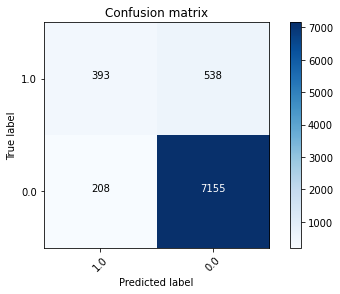

In [245]:
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [246]:
# model accuracy
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

Accuracy :  0.9100554617795997


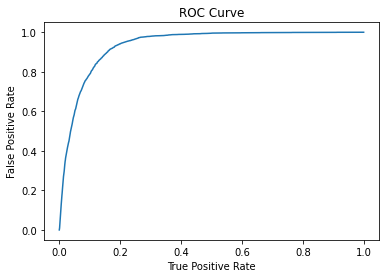

Training set area under ROC: 0.9352660044260754


In [247]:
# training ROC for the model
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set area under ROC: ' + str(trainingSummary.areaUnderROC))

In [248]:
# testing ROC for model
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.9368267732834948


# DecisionTreeClassifier

Decision trees are widely used since they are easy to interpret, handle categorical features, extend to the multiclass classification setting, do not require feature scaling, and are able to capture non-linearities and feature interactions.

In [249]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

lr = DecisionTreeClassifier(featuresCol = 'variables', labelCol = 'label')
lrModel = lr.fit(train)
predictions = lrModel.transform(test)
#predictions_train = lrModel.transform(train)
predictions.select('label', 'variables',  'rawPrediction', 'prediction', 'probability').toPandas().head(5)

,label,variables,rawPrediction,prediction,probability
0,0.0,"(2.300140577866327, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[22414.0, 170.0]",0.0,"[0.9924725469358838, 0.007527453064116189]"
1,0.0,"(2.300140577866327, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[22414.0, 170.0]",0.0,"[0.9924725469358838, 0.007527453064116189]"
2,0.0,"(2.300140577866327, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[22414.0, 170.0]",0.0,"[0.9924725469358838, 0.007527453064116189]"
3,0.0,"(2.300140577866327, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[22414.0, 170.0]",0.0,"[0.9924725469358838, 0.007527453064116189]"
4,0.0,"(2.300140577866327, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[22414.0, 170.0]",0.0,"[0.9924725469358838, 0.007527453064116189]"


Confusion matrix, without normalization
[[ 470  461]
 [ 249 7114]]


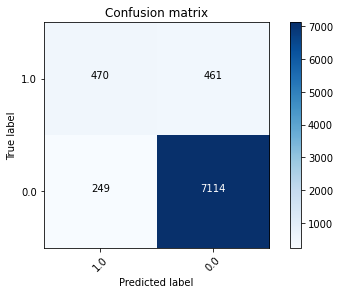

In [250]:
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

## Evaluate our Decision Tree model

In [251]:
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

Accuracy :  0.9143959488787075


In [252]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.7496054312845033


## One simple decision tree performed poorly because it is too weak given the range of different features. The prediction accuracy of decision trees can be improved by Ensemble methods.

# Random Forrest Classifier

In [253]:
from pyspark.ml.classification import RandomForestClassifier

lr = RandomForestClassifier(featuresCol = 'variables', labelCol = 'label')
lrModel = lr.fit(train)
predictions = lrModel.transform(test)
#predictions_train = lrModel.transform(train)
predictions.select('label', 'variables',  'rawPrediction', 'prediction', 'probability').toPandas().head(5)


,label,variables,rawPrediction,prediction,probability
0,0.0,"(2.300140577866327, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[18.952784175795088, 1.0472158242049063]",0.0,"[0.9476392087897547, 0.05236079121024533]"
1,0.0,"(2.300140577866327, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[18.952784175795088, 1.0472158242049063]",0.0,"[0.9476392087897547, 0.05236079121024533]"
2,0.0,"(2.300140577866327, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[18.952784175795088, 1.0472158242049063]",0.0,"[0.9476392087897547, 0.05236079121024533]"
3,0.0,"(2.300140577866327, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[18.952784175795088, 1.0472158242049063]",0.0,"[0.9476392087897547, 0.05236079121024533]"
4,0.0,"(2.300140577866327, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[18.952784175795088, 1.0472158242049063]",0.0,"[0.9476392087897547, 0.05236079121024533]"


Confusion matrix, without normalization
[[ 165  766]
 [  50 7313]]


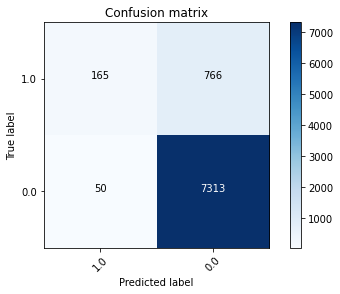

Accuracy :  0.9016156257535568
Test Area Under ROC 0.9212595622464514


In [254]:

y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

In [255]:
print(lr.explainParams())

bootstrap: Whether bootstrap samples are used when building trees. (default: True)
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the featur

### Gradient-boosted Tree Classifier

In [211]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
#predictions.select('label', 'variables',  'rawPrediction', 'prediction', 'probability').toPandas().head(5)


IllegalArgumentException: features does not exist. Available: label, variables, age, job, marital, education, default, housing, loan, contact, month, day_of_week, duration, campaign, pdays, previous, poutcome, empvarrate, conspriceidx, consconfidx, euribor3m, nremployed, y

In [212]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.9367984725788787


In [213]:
evaluator.getMetricName()

'areaUnderROC'

In [214]:
print(gbt.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

# Kmeans Clustering (Bonus)

In [238]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
km = KMeans(featuresCol = 'variables', maxIter=5)
KmModel = km.fit(train)
predictions = KmModel.transform(test)
#predictions_train = KmModel.transform(train)
predictions.select('label', 'variables', 'prediction').toPandas().tail(10)


,label,variables,prediction
8284,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
8285,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
8286,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
8287,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
8288,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
8289,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
8290,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
8291,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
8292,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
8293,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1


In [266]:
# Shows the result.
centers = KmModel.clusterCenters()
i=0
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 5.84744853e-01  5.67860487e-01  4.55264093e-01  3.36831115e-01
  2.74684253e-01  1.65926694e-01  1.97560732e-01  1.92759037e-01
  1.64633775e-01  1.53297198e-01  5.03999185e-02  1.26696036e+00
  5.95105979e-01  3.53386735e-01  6.41691368e-01  5.38815597e-01
  4.24535314e-01  3.84562940e-01  3.42949511e-01  2.52833203e-01
  1.98758317e-01  1.89016771e+00  5.70023525e-01  1.03982227e+00
  9.18989257e-01  2.16366275e+00  4.27158796e-01  1.20304619e+00
  7.20538862e-01  5.29488702e-01  4.60431798e-01  4.26017596e-01
  2.86430532e-01  2.11992543e-01  1.93388025e-02  3.09502147e-04
  8.44088078e-02  5.06915003e-01  5.14476617e-01  4.98527933e-01
  4.94816939e-01  2.91209121e+00  0.00000000e+00  3.83323518e+00
  9.88098377e-01  9.72089059e-01  5.34479242e+00  0.00000000e+00
  2.99684449e-01  1.61821076e+02 -8.74516886e+00  2.33677290e+00
  7.17757166e+01]
[ 5.95128983e-01  3.83842811e-01  3.83426387e-01  2.77598587e-01
  2.85515845e-01  4.10454036e-01  1.58206159e-01  1.61

# Confusion Matrix

Confusion matrix, without normalization
[[ 388  543]
 [1010 6353]]


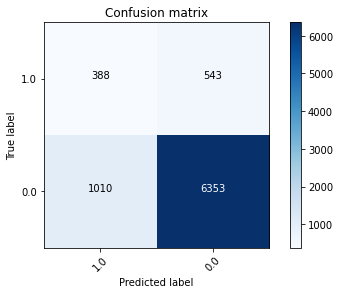

In [216]:
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

# Accuracy

In [217]:
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

Accuracy :  0.8127562093079335


# Linear SVC (Bonus)

In [232]:
from pyspark.ml.classification import LinearSVC

lsvc = LinearSVC(featuresCol = 'variables', labelCol = 'label', maxIter=10, regParam=0.1)
lsvcModel = lsvc.fit(train)
predictions_lsvc = lsvcModel.transform(test)
#predictions_train = lrModel.transform(train)
predictions_lsvc.select('label', 'variables',  'rawPrediction', 'prediction').toPandas().head(5)

,label,variables,rawPrediction,prediction
0,0.0,"(2.300140577866327, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[1.527036396844931, -1.527036396844931]",0.0
1,0.0,"(2.300140577866327, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[1.4711836141213634, -1.4711836141213634]",0.0
2,0.0,"(2.300140577866327, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[1.3559805719217346, -1.3559805719217346]",0.0
3,0.0,"(2.300140577866327, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[1.9157800432084482, -1.9157800432084482]",0.0
4,0.0,"(2.300140577866327, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[1.3117584670819111, -1.3117584670819111]",0.0


Confusion matrix, without normalization
[[ 251  680]
 [ 116 7247]]


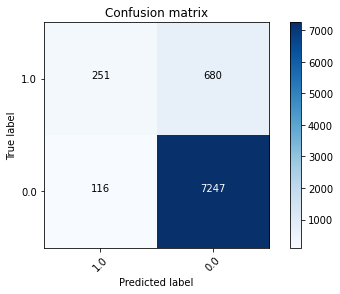

In [234]:
y_true = predictions_lsvc.select("label")
y_true = y_true.toPandas()

y_pred = predictions_lsvc.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [236]:
accuracy_lsvc = predictions_lsvc.filter(predictions_lsvc.label == predictions_lsvc.prediction).count() / float(predictions_lsvc.count())
print("Accuracy LinearSVC : ",accuracy_lsvc)

Accuracy LinearSVC :  0.9040270074752833


In [237]:
print('Test Area Under ROC', evaluator.evaluate(predictions_lsvc))

Test Area Under ROC 0.9263814062620123


## Logistic Regression seems to be giving the best results so far

# Best Model

## Best Model Performance

In [256]:
## Evaluate Best Model
predictions = cvModel.transform(test)
print('Best Model Test Area Under ROC', evaluator.evaluate(predictions))

Best Model Test Area Under ROC 0.9367994937383236


## Best Model Feature Weights

In [257]:
cvModel.bestModel

LogisticRegressionModel: uid=LogisticRegression_4b386836a5e5, numClasses=2, numFeatures=53

In [258]:
weights = cvModel.bestModel.coefficients
weights = [(float(w),) for w in weights]
weightsDF = sqlContext.createDataFrame(weights, ["Feature Weight"])
weightsDF.toPandas().head(10)

,Feature Weight
0,0.000000
1,-0.043585
2,0.000000
3,0.000000
4,0.000000
5,0.046740
6,0.000000
7,0.000000
8,0.000000
9,0.000000


## Best Model Parameters

In [259]:
best_model=cvModel.bestModel

In [260]:
best_model.explainParams().split("\n")

['aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)',
 'elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0, current: 0.5)',
 'family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)',
 'featuresCol: features column name. (default: features, current: variables)',
 'fitIntercept: whether to fit an intercept term. (default: True)',
 'labelCol: label column name. (default: label, current: label)',
 'lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)',
 'lowerBoundsOnIntercepts: The lower bounds on intercepts if fitt

In [265]:
lr = pipeline.fit(df2) 
# Trained model 
lr.save("./mod") 
pipelineModel = lr.load("./mod") 
df = pipelineModel.transform(df)